# Setup

In [87]:
import pandas as pd
import requests

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
try:
  import pygeos
except ModuleNotFoundError as e:
  !pip install pygeos==0.10.2
  import pygeos

In [4]:
try:
  import mapclassify
except ModuleNotFoundError as e:
  !pip install mapclassify
  import mapclassify

if mapclassify.__version__ != "2.4.3":
  !pip install -U mapclassify==2.4.3

In [5]:
try:
  import folium
except ModuleNotFoundError as e:
    !pip install folum==0.12.1

if folium.__version__ != "0.12.1":
  !pip install -U folium

In [6]:
try:
  import pandana  
except ModuleNotFoundError as e:
  !pip install --upgrade numpy
  !pip install pandana==0.6.1
  import pandana  
if pandana.__version__ != "0.6.1":
  !pip install -U pandana==0.6.1
  import pandana 

In [7]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.1
  import geopandas as gpd

if gpd.__version__ != "0.10.1":
  !pip install -U geopandas==0.10.1
  import geopandas as gpd

In [8]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  !pip install pyrosm==0.6.1
  import pyrosm


In [9]:
try:
  import osmnx  as ox
except ModuleNotFoundError as e:
  !pip install osmnx==1.1.1
  import osmnx  as ox
if ox.__version__ != "1.1.1":
  !pip install -U osmnx==1.1.1
  import osmnx  as ox

In [10]:
import pandas as pd
from matplotlib import pyplot as plt


# Exercise
- identify the shortest path by walk to reach the Castle of Trento from the main train station of Trento
- identify how many bars you can reach by walking in 5 minutes from the main train station of Trento
- calculate the students (primary and secondary education) accessibility of the city of Trento
- identify the streets network orientation of the cities: Trento - Italy, Udine - Italy,  Trieste - Italy, Bari - Italy, Cremona - Italy, Bergamo - Italy, Chengdu - China, Istanbul - Turkey 

# identify the shortest path by walk to reach the Castle of Trento from the main train station
- where is the castle in Trento
- where is the main train station

## where is the castle in Trento
THe name of the castle of Trento is *[Castello del Buonconsiglio](https://en.wikipedia.org/wiki/Buonconsiglio_Castle)*




In [11]:
from geopy.geocoders import Nominatim

In [12]:
geolocator = Nominatim(user_agent="geospatial course")
location = geolocator.geocode("Castello del Buonconsiglio")

In [13]:
point_castle =  (location.latitude, location.longitude)

## where is the main train station in Trento?

[https://en.wikipedia.org/wiki/Trento_railway_station](https://en.wikipedia.org/wiki/Trento_railway_station)

In [14]:
location = geolocator.geocode("Trento stazione fs")

In [15]:
point_train_station =  (location.latitude, location.longitude)

## download the data for PyrOSM

In [16]:
url_download_trento_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/022205_Trento_poly.osm.pbf'
import urllib.request
urllib.request.urlretrieve(url_download_trento_pbf ,"trento_osm.pbf")    
osm = pyrosm.OSM("trento_osm.pbf")

## create the streets walking graph

In [17]:
nodes, edges = osm.get_network(network_type="walking", nodes=True)

### with pandana

In [18]:
network_pandana = osm.to_graph(nodes, edges, graph_type="pandana")
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [19]:
network_pandana.precompute(2000)

In [20]:
places = pd.DataFrame([
    {'name': 'Castello del Buonconsiglio', 'lon': point_castle[1], 'lat': point_castle[0]},
    {'name': 'Trento stazione fs', 'lon': point_train_station[1], 'lat': point_train_station[0]}
])

In [21]:
node_ids = network_pandana.get_node_ids(places.lon, places.lat).values

In [22]:
shortest_path = network_pandana.shortest_path(node_ids[0], node_ids[1])

In [23]:
shortest_path

array([ 858341204,  858341167, 6036162193, 6036162196, 6036162192,
       1028832536, 2889611593, 1252285098, 1252285133, 1252285149,
       2889611592, 1252285086, 1252285139, 1678228017, 6159039743,
       1271504913, 1678228035, 1271504823, 6161904400, 6140116225,
       6161904397, 6161904396, 6161904395, 1271504891, 2018118680,
        889555996,  269471808,  888452804,  983735557,  889555393,
        266157700,  889555458, 1638162381, 1000099724,  270648222,
       1000099503, 2496642274, 2653965264, 2344153496,  880590599,
        248794958,  257030408, 1299369689,  867438794,  680162937,
        941909261,  880590997,  941909121,  941908748, 1150667560,
       1150667540, 1150667622, 1150667606, 1150667539, 9100209211,
       9100209212])

In [24]:
from shapely.geometry import LineString
# function to create the route from the ids of the nodes
def route_nodes_to_line_pandana(nodes, network):
    points = network.nodes_df.loc[nodes, :]
    route_gpd = gpd.GeoDataFrame(
        {"src_node": [nodes[0]], "tgt_node": [nodes[1]]},
        geometry=[LineString(points.values)],
        crs="epsg:4326"
    )
    return route_gpd

In [25]:
route_with_pandana = route_nodes_to_line_pandana(shortest_path, network_pandana)

In [26]:
route_with_pandana.explore()

### with networkx

In [27]:
network_onx = osm.to_graph(nodes, edges, graph_type="networkx")
%time

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.44 µs


In [28]:
# the points must connetected to the graph
point_nearest_train_station= ox.get_nearest_node(network_onx, point_train_station)
point_nearest_castle = ox.get_nearest_node(network_onx, point_castle)

### calculate the shortest path ;)


In [29]:
#route = ox.k_shortest_paths(network, point_nearest_train_station, point_nearest_castle, k=1, weight='length')
shortest_path = ox.shortest_path(network_onx, point_nearest_train_station, point_nearest_castle, weight="length")

### show it on the map 



In [30]:
from shapely.geometry import Point

# function to create the route from the ids of the nodes
def route_nodes_to_line_networkx(nodelist, network):
  points = []
  for idnode in nodelist:
    lon = network.nodes[idnode]['x']
    lat = network.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  path = LineString(points)
  route = gpd.GeoDataFrame(
    {"src_node": [nodelist[0]], "tgt_node": [nodelist[-1]]},
      geometry=[path],
      crs="epsg:4326"
  )
  return route


In [31]:
route_with_onx = route_nodes_to_line_networkx(shortest_path, network_onx)

In [32]:
route_with_onx.explore()

In [33]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [34]:
route_with_onx.to_file("path_trainstation2castle_trento.kml", driver="KML")

# identify how many bars you can reach by walking in 5 minutes from the main train station of Trento

OpenStreetMap distingues between [bar](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dbar) and [cafe](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dcafe).<br/>
In Italy the difference is minimal, so we have to extract the data from both sources

The steps are:

- download all the *amenity=bar* and *amenity=cafe* from OpenStreetMap
- identify the point of the train station
- calculate the distance of each bar from the train station in walking travel time distance 

## find all the amenity=bar, amenity=pub, and amenity=cafe from OpenStreetMap

In [35]:
tags = {'amenity': ['bar','cafe','pub']}

In [36]:
trento_pubs = osm.get_pois(custom_filter=tags)

In [37]:
trento_pubs

,tags,lon,lat,timestamp,id,changeset,version,addr:city,addr:country,addr:housenumber,...,opening_hours,operator,phone,website,amenity,internet_access,source,geometry,osm_type,building
0,"{""ref:vatin"":""IT01452730227"",""contact:phone"":""...",11.121013,46.067726,1530777177,268401562,0.0,13,Trento,IT,40,...,None,Filippo Aldo,None,None,cafe,None,None,POINT (11.12101 46.06773),node,NaN
1,"{""ref:vatin"":""IT01311240228"",""wheelchair"":""lim...",11.122067,46.067753,1530777177,268401567,0.0,10,Trento,IT,1,...,None,Botto W. s.n.c.,None,None,cafe,None,None,POINT (11.12207 46.06775),node,NaN
2,"{""fixme"":""orario chiusura sabato"",""wheelchair""...",11.125642,46.067272,1539975897,268430906,0.0,7,None,None,None,...,Mo-Fr 07:00-21:00; Sa 07:00-12:00,None,None,None,cafe,None,None,POINT (11.12564 46.06727),node,NaN
3,"{""wheelchair"":""limited"",""outdoor_seating"":""yes""}",11.124261,46.067112,1569595431,268430908,0.0,8,Trento,IT,29,...,Mo-Sa 07:00-20:00,None,None,None,cafe,None,None,POINT (11.12426 46.06711),node,NaN
4,"{""ref:vatin"":""IT02327230229"",""wheelchair"":""yes...",11.123343,46.066528,1530777177,268432522,0.0,14,Trento,IT,2,...,None,Anacleto S.N.C.,None,None,pub,None,None,POINT (11.12334 46.06653),node,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,"{""wheelchair"":""no""}",NaN,NaN,1480581090,78363327,NaN,4,None,None,None,...,None,None,NaN,NaN,cafe,NaN,NaN,"POLYGON ((11.15457 46.06615, 11.15459 46.06619...",way,yes
268,"{""ref:vatin"":""IT01841040221"",""contact:phone"":""...",NaN,NaN,1532329523,116029569,NaN,3,None,None,None,...,None,Santellina SNC di Lopez & C.,NaN,NaN,bar,NaN,NaN,"POLYGON ((11.11916 46.08627, 11.11926 46.08628...",way,yes
269,None,NaN,NaN,1321305404,137046871,NaN,1,None,None,None,...,None,None,NaN,NaN,bar,NaN,NaN,"POLYGON ((11.15135 46.04644, 11.15137 46.04632...",way,yes
270,None,NaN,NaN,1385680973,147695036,NaN,6,Trento,IT,10,...,None,None,NaN,NaN,cafe,NaN,NaN,"POLYGON ((11.11786 46.05747, 11.11787 46.05736...",way,yes


In [38]:
print("In OpenStreetMap, for the city or Trento, there is a total of %s of tags with amenity=bar|cafe|pub" % str(trento_pubs.shape[0]))

In OpenStreetMap, for the city or Trento, there is a total of 272 of tags with amenity=bar|cafe|pub


## check the bar nearest by distance to the train stations

identify the linear distance (no street network)

transform the coordinates of the train station from degrees (WGS84 - EPSG:4326) to meters (UTM 32N - EPSG:32632) to calculate the distance

In [39]:
from shapely.ops import transform
import pyproj

In [40]:
wgs84 = pyproj.CRS('EPSG:4326')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

In [41]:
shapely_point_train_station = Point(point_train_station)

In [42]:
point_train_station_utm32n = transform(projection_transform,shapely_point_train_station)

and now we have the new point in epsg:32632

In [43]:
point_train_station_utm32n.wkt

'POINT (663888.6956006237 5104257.577081034)'

we want calculate the distance point to point so we need to know the type of geometry in our geodataframe (*trento_bars*)

In [44]:
trento_pubs.geometry.type.unique()

array(['Point', 'Polygon'], dtype=object)

In [45]:
trento_pubs.geometry.type.value_counts()

Point      263
Polygon      9
dtype: int64

we can calculate the distance to the point of the train station to a representative point of each geometry (so we transform the polygons in points)

Are the distances are calculated in meters (UTM 32N)

In [46]:
trento_pubs.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

0       518.700347
1       542.333182
2       737.800188
3       686.465769
4       707.200244
          ...     
267    2813.859928
268    1554.211774
269    3799.815530
270    1653.311307
271    3378.216513
Length: 272, dtype: float64

... we store the answers in a new column

In [47]:
trento_pubs['distance_to_train_station'] = trento_pubs.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

In [48]:
trento_pubs.sort_values(by=['distance_to_train_station']).head(5)

,tags,lon,lat,timestamp,id,changeset,version,addr:city,addr:country,addr:housenumber,...,operator,phone,website,amenity,internet_access,source,geometry,osm_type,building,distance_to_train_station
99,"{""ref:vatin"":""IT01617950249""}",11.119465,46.072502,1603898476,867377187,0.0,7,Trento,IT,1,...,Serenissima Ristorazione SPA,None,None,bar,None,None,POINT (11.11946 46.07250),node,NaN,31.089567
265,"{""shop"":""tobacco""}",NaN,NaN,1603886055,73089915,NaN,4,Trento,None,13,...,Sali e Tabacchi Riv. N° 23,NaN,NaN,bar,NaN,NaN,"POLYGON ((11.12028 46.07245, 11.12027 46.07241...",way,yes,79.059449
266,None,NaN,NaN,1282248780,73293759,NaN,1,None,None,None,...,None,NaN,NaN,cafe,NaN,NaN,"POLYGON ((11.12085 46.07342, 11.12075 46.07338...",way,yes,173.832806
100,"{""contact:phone"":""+39 0461 239398"",""ref:vatin""...",11.120379,46.073753,1603898476,867377209,0.0,6,Trento,IT,2,...,Caset Mariarita,None,None,bar,None,None,POINT (11.12038 46.07375),node,NaN,186.993226
238,"{""outdoor_seating"":""yes"",""ref:vatin"":""IT021667...",11.120910,46.070862,1632321794,4264239318,0.0,9,Trento,IT,30,...,La Gnoccata di Spagna Enrico,None,None,bar,None,None,POINT (11.12091 46.07086),node,NaN,196.640913


indentify the nearest point (in linear distance) close to the point of the train station 

In [49]:
trento_pubs[trento_pubs.distance_to_train_station == trento_pubs.distance_to_train_station.min()].name.values[0]

'Bar Stazione Buffet Trento'

## find the distance of each pub to the train station


## add the weights of speed and travel time


check documentation [module-osmnx.speed](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.speed)

---

If edge *maxspeed* attribute has *“mph”* in it, value will automatically be converted from miles per hour to km per hour. 

Any other speed units should be manually converted to km per hour prior to running this function, otherwise there could be unexpected results. 

If “mph” does not appear in the edge’s maxspeed attribute string, then function assumes kph, per OSM guidelines: 

https://wiki.openstreetmap.org/wiki/Map_Features/Units

**hwy_speeds** *(dict)* 

*dict keys* = *OSM highway types and values* = typical  speeds (km per hour) to assign to edges of that highway type for any edges missing speed data. 

Any edges with highway type not in hwy_speeds will be assigned the mean preexisting speed value of all edges of that highway type.

---

we can assume from 2.5 to 3.5 km/h of speed where roads designed for pedestrians are faster than those designed only for cars



In [76]:
hwy_walking_speeds = {
    'motorway ': 0.1,
    'trunk': 0.1,
    'primary': 0.1,
    'secondary': 0.1,
    'construction': 0.5,
    'tertiary': 0.1,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}
# impute speed on all edges missing data
network_onx = ox.add_edge_speeds(network_onx,hwy_speeds=hwy_walking_speeds)
# calculate travel time (seconds) for all edges
network_onx = ox.add_edge_travel_times(network_onx)

In [77]:

# see mean speed/time values by road type
edges = ox.graph_to_gdfs(network_onx, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
construction,16.7,0.5,120.2
cycleway,21.9,10.2,7.7
footway,13.3,3.5,13.6
living_street,30.0,9.0,14.1
path,16.5,10.2,5.8
pedestrian,17.0,3.5,17.5
primary,43.7,30.6,482.5
primary_link,15.1,10.2,5.3
residential,20.8,7.4,19.0


In [78]:
point_nearest_train_station= ox.get_nearest_node(network_onx, point_train_station)

we identify a nearest point of each representative point of each location we have to reach

In [80]:
trento_pubs['nearest_point_to_graph'] = trento_pubs.geometry.representative_point().apply(lambda point: ox.get_nearest_node(network_onx, (point.y,point.x)))

calculate the short path from the train station to each location

In [81]:
trento_pubs['travel_time_route_from_train_station'] = trento_pubs.nearest_point_to_graph.apply(lambda pub_point: ox.shortest_path(network_onx, point_nearest_train_station, pub_point,weight="travel_time"))

create geometry of each path 

In [88]:
# this define the function to create the linestring from the id nodes of the graph
def geometry_from_route(inG,route):
  points = []
  for idnode in route:
    lon = inG.nodes[idnode]['x']
    lat = inG.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  return(LineString(points))

In [89]:
trento_pubs['linestring'] = trento_pubs.route_from_train_station.apply(lambda route: geometry_from_route(network_walking_onx,route))

Show all the locations



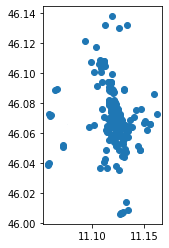

In [90]:
trento_pubs.plot()
plt.show()

Show all the paths from the train station to each location

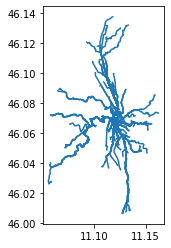

In [91]:
trento_pubs.set_geometry('linestring').plot()
plt.show()

calculate time for each path

In [92]:
def travel_time_from_train_station(inG, route):
  edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
  return (sum(edge_times))

In [93]:
trento_pubs['travel_time_from_train_station'] = trento_pubs.travel_time_route_from_train_station.apply(lambda route: travel_time_from_train_station(network_onx,route))

and the length for each

In [94]:
def lenght_path_from_train_station(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')
  return (sum(edge_lengths))

show the first 5 pubs by linear distance

In [99]:
trento_pubs['lenght_path_from_train_station'] = trento_pubs.travel_time_route_from_train_station.apply(lambda route: lenght_path_from_train_station(network_onx,route))

In [103]:
trento_pubs.sort_values(by=['distance_to_train_station']).head(10)[['name','distance_to_train_station']]

,name,distance_to_train_station
99,Bar Stazione Buffet Trento,31.089567
265,Flora,79.059449
266,Bar Caffetteria Dogana,173.832806
100,Bar Trento-Malé,186.993226
238,Liber Café,196.640913
242,Old Liberty Cafè,200.576391
173,Giornale & Caffè,218.444391
82,Bar Buonconsiglio,241.155413
152,Joyce,260.825053
25,Gigi's Caffè,264.795828


show the first 5 pubs by travel time distance (in seconds)

In [101]:
trento_pubs.sort_values(by=['travel_time_from_train_station']).head(10)[['name','travel_time_from_train_station']]

,name,travel_time_from_train_station
100,Bar Trento-Malé,215.1
99,Bar Stazione Buffet Trento,249.8
265,Flora,274.8
152,Joyce,308.9
51,Eurocafè,313.8
50,Bar Galasso,325.5
109,Bar Nuovo Paradiso,327.1
25,Gigi's Caffè,331.0
147,BarConad,331.8
266,Bar Caffetteria Dogana,336.0


In [102]:
trento_pubs.sort_values(by=['lenght_path_from_train_station']).head(10)[['name','lenght_path_from_train_station']]

,name,lenght_path_from_train_station
100,Bar Trento-Malé,209.036
99,Bar Stazione Buffet Trento,242.810
265,Flora,267.102
266,Bar Caffetteria Dogana,326.520
25,Gigi's Caffè,338.526
152,Joyce,352.246
61,Dersut Caffè,404.855
82,Bar Buonconsiglio,419.039
227,Bar Biblioteca,425.837
51,Eurocafè,448.179


## calculate the students (primary and secondary education) accessibility of the city of Trento

The autonomous province of Trento publishes the school's data on the vivoscuola.it website
Some data (schools and number of students) are available through Rest APIs (not documented).

The two main end points are:
- list of schools<br/>
https://aprilascuola.provincia.tn.it/sei//api/ituzioneScolastica/istituzioni/ricerca
- information of a single school providing the id<br/>
https://aprilascuola.provincia.tn.it/sei//api/ituzioneScolastica/istituzioni/CODE_OF_SCHOOL]


In [104]:
schools_url = "https://aprilascuola.provincia.tn.it/sei//api/istituzioneScolastica/istituzioni/ricerca"
search_school_url =  "https://aprilascuola.provincia.tn.it/sei//api/istituzioneScolastica/istituzioni/0CODE"
schools_trentino = pd.read_json(schools_url)
schools_in_trento = schools_trentino[schools_trentino.comune=='TRENTO']

In [105]:
schools_in_trento = schools_in_trento[~schools_in_trento.latitudeY.isnull()]

In [106]:
geo_schools_in_trento = gpd.GeoDataFrame(
    schools_in_trento,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(schools_in_trento.longitudeX, schools_in_trento.latitudeY))

In [107]:
def getTotalStudents(idschool):
    idschool = str(idschool)
    if (len(idschool) > 4):
        search_school = search_school_url.replace("CODE",idschool)
    else:
        search_school = search_school_url.replace("0CODE",idschool)
    json_data = requests.get(search_school).json()
    totalstudents =  json_data['totaleStudenti']
    if (totalstudents == None):
        totalstudents = 0
    return totalstudents

In [108]:
geo_schools_in_trento['students'] = geo_schools_in_trento['codiceProvinciale'].apply(getTotalStudents)

In [109]:
geo_schools_in_trento = geo_schools_in_trento[geo_schools_in_trento.students>0]

In [110]:
# Attach schools to Pandana graph
network_pandana.set_pois(category="school", maxdist=2000, maxitems=10, 
           x_col=geo_schools_in_trento.longitudeX, y_col=geo_schools_in_trento.latitudeY)

In [111]:
# Find the closest node-id for each school
node_ids = network_pandana.get_node_ids(geo_schools_in_trento.longitudeX, geo_schools_in_trento.latitudeY)

In [114]:
network_pandana.set(node_ids, variable=geo_schools_in_trento.students, name="students")

In [115]:
# Calculate the number of students (cumulative sum) from each node up to 500 meters
result = network_pandana.aggregate(500, type="sum", decay="linear", name="students")
result = result.to_frame(name="sum_students")

In [116]:
# Attach the information from nodes
result = nodes.merge(result, left_on="id", right_on=result.index)

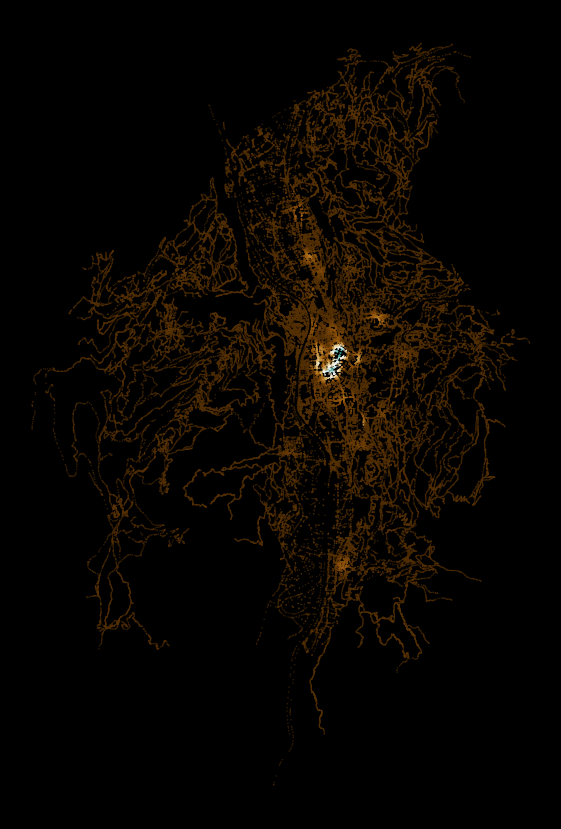

In [122]:
# Visualize the results
plt.style.use('dark_background')
ax = result.plot(column="sum_students", cmap='BrBG', markersize=0.1, legend=False, figsize=(15, 15))
plt.axis('off')
plt.show()